In [1]:
import itertools
import matplotlib.pyplot as plt
import math
import random
from statistics import mean
import numpy as np
# from typing import Tuple,List,Dict,Set
import operator
from functools import reduce

In [2]:
# Initialising
# features = Tuple[float,...]
classId = int
# dataset = Dict[classId,List[data]]
GOLD_STANDARD_CLASS_STD = 0.2
DIMENSIONS = 2
EPOCHS = 10
# N_CLASSES = 2
CLASSES = ['class_1','class_2']
N_SAMPLES = 1000

def get_data(samples: int = N_SAMPLES, dimensions: int = DIMENSIONS, classes: list = CLASSES,sd=GOLD_STANDARD_CLASS_STD):
    """Generate sythetic data, returns list of dictionries, each record has class_id,feature"""
    distributions = []
    for _ in classes:
        mean = random.random()
        distributions.append((mean,sd))
    #generate data
    data = []
    for _ in range(samples):
        data_record ={}
        class_id = random.randrange(0,len(classes))
        mean,sd = distributions[class_id]
        features = tuple(random.normalvariate(mean,sd) for _ in range(dimensions))
        data_record['class_id'] = classes[class_id]
        data_record['feature'] = features
        data.append(data_record)
    return data

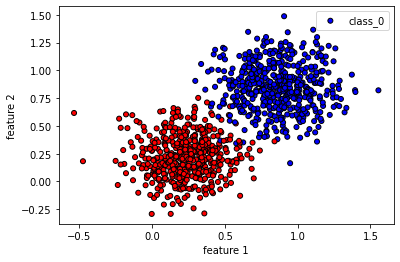

In [7]:
data = get_data()
x,y,c = zip(*[(*da['feature'],da['class_id']) for da in data])
colors = {'class_1':'red','class_2':'blue'}
plt.scatter(x,y,c=[colors[cl] for cl in c],s=25,edgecolors="k")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['class_0','class_1'],loc='upper right')
plt.show()

In [8]:
print(f'x: {len(x)},y: {len(y)} c: {len(c)}')

x: 1000,y: 1000 c: 1000


In [9]:
# Split data
import collections
from sklearn.model_selection import train_test_split

In [10]:
TRAIN_SIZE = 0.7
TEST_SIZE = 0.15
VAL_SIZE = 0.15

In [11]:
def train_val_test_split(X,y,train_size):
    """split dataset into data splits"""
    X_train,X_,y_train,y_ = train_test_split(X,y,train_size=TRAIN_SIZE,stratify=y)
    X_val,X_test,y_val,y_test = train_test_split(X_,y_,train_size=0.5,stratify=y_)
    return X_train,X_test,X_val,y_train,y_test,y_val

   

In [12]:
# Create data splits
# X_train,X_test,X_val,y_train,y_test,y_val = train_val_test_split([(i,j) for i,j in zip(x,y)],c,train_size=TRAIN_SIZE)
X_train,X_test,X_val,y_train,y_test,y_val = train_val_test_split(np.array([x,y]).T,np.array(c),train_size=TRAIN_SIZE)


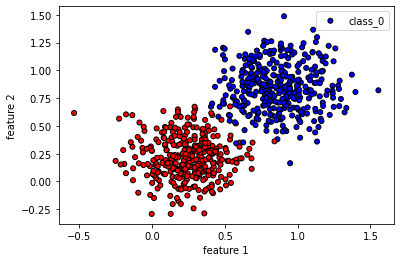

In [13]:

plt.scatter(X_train[:,0],X_train[:,1],c=list(map(lambda x:colors[x] ,y_train)),s=25,edgecolors="k")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['class_0','class_1'],loc='upper right')
plt.show()

In [14]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_train: {X_test.shape}, y_train: {y_test.shape}')
print(f'X_train: {X_val.shape}, y_train: {y_val.shape}')
print(f'Sample point: {X_train[0]} → {y_train[0]}')

X_train: (700, 2), y_train: (700,)
X_train: (150, 2), y_train: (150,)
X_train: (150, 2), y_train: (150,)
Sample point: [1.06357902 0.61094694] → class_2


In [15]:
# how many samples per each data split
#class distribution
class_count = dict(collections.Counter(c))
print(f'Classses:  {class_count}')
print(f'0:1 = {class_count["class_1"]/class_count["class_2"]:.2f}')

Classses:  {'class_2': 503, 'class_1': 497}
0:1 = 0.99


In [16]:
# per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print(f'train 0:1 ={train_class_counts["class_1"]/train_class_counts["class_2"]:.2f}')
print(f'val 0:1 ={val_class_counts["class_1"]/val_class_counts["class_2"]:.2f}')
print(f'test 0:1 ={test_class_counts["class_1"]/test_class_counts["class_2"]:.2f}')

train 0:1 =0.99
val 0:1 =1.00
test 0:1 =0.97


In [17]:
### Now do the lable encoding , labels are in text. We convert them to numbers ( we use label encoder than sklearn one)

In [18]:
import itertools

In [19]:
class LabelEncoder:
    """Label encoder for class labels"""
    def __init__(self,class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v:k for k,v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f'<LabelEncoder(num_classes={len(self)}>'
    
    def fit(self,y):
        classes = np.unique(y)
        for i,class_ in enumerate(classes):
            self.class_to_index[class_]=i
        self.index_to_class = {v:k for k,v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self,y):
        encoded = np.zeros((len(y)),dtype=int)
        for i,item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
                           
    def decode(self,y):
        classes = []
        for i,item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes
    
    def save(self,fp):
        with open(fp,'w') as fp:
            contents = {'class_to_index':self.class_to_index}
            json.dump(contents,fp, indent=4, sort_keys=False)
                           
                           
    @classmethod
    def load(cls,fp):
        with open(fp,'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [20]:
#Fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'class_1': 0, 'class_2': 1}

In [21]:
#Encoder
print(f'y_train[0]: {y_train[0]}')
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print(f'y_train[0]: {y_train[0]}')
print(f'decode: {label_encoder.decode([y_train[0]])}')

y_train[0]: class_2
y_train[0]: 1
decode: ['class_2']


In [22]:
# Maintain class weights will help for class inbalance issues but we've got balanced classes
# Class weights
counts = np.bincount(y_train)
class_weights = {i:1.0/count for i,count in enumerate(counts)}
print(f'counts: {counts}\nweights: {class_weights}')

counts: [348 352]
weights: {0: 0.0028735632183908046, 1: 0.002840909090909091}


In [23]:
# Standardize data
# mean,std = X_train.mean(),X_train.std()
# std_scaler = lambda x,mean,std:(x-mean)/std
# X_train = std_scaler(X_train,mean,std)
# X_test = std_scaler(X_test,mean,std) 
# X_val= std_scaler(X_val,mean,std)

In [24]:
print(f'X_test[0]: mean: {np.mean(X_test[:,0],axis=0):.1f}, std: {np.std(X_test[:,0],axis=0):.1f}')
print(f'X_test[1]: mean: {np.mean(X_test[:,1],axis=0):.1f}, std: {np.std(X_test[:,0],axis=0):.1f}')

X_test[0]: mean: 0.5, std: 0.4
X_test[1]: mean: 0.5, std: 0.4


In [27]:
y_train =y_train#.reshape(-1,1) 
y_test = y_test#.reshape(-1,1)
y_val = y_val#.reshape(-1,1)

INPUT_DIM = X_train.shape[1]
NUM_CLASS = len(label_encoder.classes)
#Initialize random weights
W1 =  .001*np.random.randn(INPUT_DIM)
b = 0
print(f'W: {W1.shape}')

W: (2,)


In [28]:
def sigmoid(a):
    return 1/(1+np.exp(-a))

In [29]:
def forward(X,W=W1,b=b):
    return sigmoid(np.dot(X,W)+b)

In [30]:
def cross_entropy(y,yhat):
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(y_hat))

In [32]:
lr =0.0001
for i in range(350):
    y_hat = forward(X_train,W1,b)
    loss = cross_entropy(y_train,y_hat)
#     print(y_hat.shape,y_train.shape,X_train.shape)
    W1 -=lr*X_train.T.dot(y_hat-y_train)
    b -=lr*(y_hat-y_train).sum()
    if i%30==0:
        accuracy = np.mean(np.equal(y_train,np.round(y_hat)))
        print(f'i {i},loss: {loss} accuracy: {accuracy:.3f}')

i 0,loss: 0.6931454084403161 accuracy: 0.537
i 30,loss: 0.5856655388007262 accuracy: 0.596
i 60,loss: 0.5581098875633057 accuracy: 0.727
i 90,loss: 0.5585829085333683 accuracy: 0.829
i 120,loss: 0.5701340009405893 accuracy: 0.876
i 150,loss: 0.5863418975799662 accuracy: 0.920
i 180,loss: 0.6045282696447506 accuracy: 0.943
i 210,loss: 0.6234982071645248 accuracy: 0.959
i 240,loss: 0.6426869861851405 accuracy: 0.966
i 270,loss: 0.6618125230437545 accuracy: 0.970
i 300,loss: 0.680726449900886 accuracy: 0.974
i 330,loss: 0.699347490598328 accuracy: 0.976


In [43]:
# Evaluate
class LogisticRegression:
    def predict(self,x,W1=W1,b=b):
        pred = np.round(forward(x,W1,b))
        return pred

In [45]:
model = LogisticRegression()
pred_train = model.predict(X_train)
train_acc=np.mean(np.equal(y_train,pred_train))
pred_test = model.predict(X_test)
test_acc=np.mean(np.equal(y_test,pred_test))
# pred_test = model.predict(X_test)
# # pred_test[:10],y_train[:10]
# train_acc = np.mean(np.equal(y_train,np.round(pred_train)))
# test_acc =np.mean(np.equal(y_test,np.round(pred_test)))#np.mean(y_test==pred_test)
# print(f'train_acc: {train_acc:.2f}, test_acc: {test_acc:.2f}')
train_acc,test_acc

(0.9785714285714285, 0.9933333333333333)

In [46]:
# plot the decisio boundary
def plot_decision_boundary(model,X,y):
    """plot the decision boundary for a model
    inputs: 2D
    Arguments:
        model: trained model
        X: numpy ndarray  2D input(shape (N,2))
        y numpy ndarray 1D input (shape(N,))"""
    x_min,x_max = X[:,0].min() - 0.1, X[:,0].max()+.01
    y_min,y_max = X[:,1].min() - 0.1, X[:,1].max()+.01
    xx,yy = np.meshgrid(np.linspace(x_min,x_max,101),np.linspace(y_min,y_max,101))
    
    # prediction
    x_in = np.c_[xx.ravel(),yy.ravel()]
    y_pred = np.round(model.predict(x_in)).reshape(xx.shape)
#     y_pred = np.argmax(y_pred,axis=1).reshape(xx.shape)
    
    # plot boundary
    plt.contourf(xx,yy,y_pred,cmap=plt.cm.Spectral,alpha=0.8)
    plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(),xx.max())
    plt.ylim(yy.min(),yy.max())
    

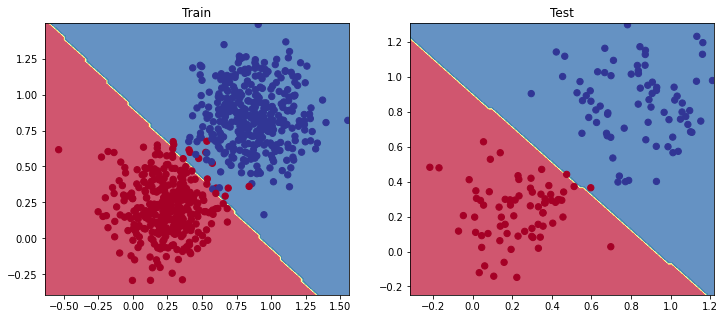

In [47]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model=model,X=X_train,y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model,X=X_test,y=y_test)
plt.show()